# Trans-Effects

## Install necessary Packages

In [7]:
!pip install cptac
!pip install --upgrade cptac
!pip install pyensembl


Requirement already up-to-date: cptac in c:\users\chels\anaconda3\lib\site-packages (0.8.1)


In [8]:
!pyensembl install --release 99 --species human

2020-07-01 12:14:18,300 - pyensembl.shell - INFO - Running 'install' for EnsemblRelease(release=99, species='homo_sapiens')
2020-07-01 12:14:19,094 - pyensembl.sequence_data - INFO - Loaded sequence dictionary from C:\Users\chels\AppData\Local\pyensembl\GRCh38\ensembl99\pyensembl\GRCh38\ensembl99\Cache\Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
2020-07-01 12:14:19,273 - pyensembl.sequence_data - INFO - Loaded sequence dictionary from C:\Users\chels\AppData\Local\pyensembl\GRCh38\ensembl99\pyensembl\GRCh38\ensembl99\Cache\Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
2020-07-01 12:14:19,454 - pyensembl.sequence_data - INFO - Loaded sequence dictionary from C:\Users\chels\AppData\Local\pyensembl\GRCh38\ensembl99\pyensembl\GRCh38\ensembl99\Cache\Homo_sapiens.GRCh38.pep.all.fa.gz.pickle


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cptac
import pyensembl
from scipy import stats

## Download all the data

In [10]:
cptac.download(dataset="luad")
cptac.download(dataset="hnscc")
cptac.download(dataset="ovarian")
cptac.download(dataset="colon")
cptac.download(dataset="brca")
cptac.download(dataset="lscc")

True

In [11]:
luad = cptac.Luad()
hnscc = cptac.Hnscc()
ovarian = cptac.Ovarian()
colon = cptac.Colon()
brca = cptac.Brca()
lscc = cptac.Lscc()

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py, line 2)


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


version 3scc v3.2.......                  


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py, line 6)


In [12]:
luad_cnv = luad.get_CNV()
hnscc_cnv = hnscc.get_CNV()
ovarian_cnv =  ovarian.get_CNV()
colon_cnv = colon.get_CNV()
brca_cnv = brca.get_CNV()
lscc_cnv = lscc.get_CNV()

In [83]:
luad_cnv.min()

Name
A1BG      -0.6094
A1CF      -0.5780
A2M       -0.6213
A2ML1     -0.6213
A3GALT2   -0.4437
            ...  
ZYG11A    -0.4437
ZYG11B    -0.4437
ZYX       -0.5708
ZZEF1     -0.6338
ZZZ3      -0.4090
Length: 19267, dtype: float64

In [13]:
luad_prot = luad.get_proteomics()
hnscc_prot = hnscc.get_proteomics()
ovarian_prot = ovarian.get_proteomics()
colon_prot = colon.get_proteomics()
brca_prot = brca.get_proteomics()
lscc_prot = lscc.get_proteomics()

In [14]:
# Used to find the gene locations
ensembl = pyensembl.EnsemblRelease()

## Create Counts Table

In [15]:
def separate(hiCut, lowCut, data):
  """
  Counts the Number of patients with high and low value for each gene.
  """
  sepDict = dict()
  for column in data:
    numHi = 0
    numLow = 0
    numNeu = 0
    for i in data[column]:
        if i >= hiCut:
            numHi += 1
        elif i <= lowCut:
            numLow += 1
        else:
            numNeu += 1 
    sepDict[column] = [numHi, numNeu, numLow]
  return sepDict

In [16]:
def get_counts_and_average(data):
  """
  Takes a CNV dataframe and generates a dataframe with the counts of high, low and neutral values
  """
  df = pd.DataFrame(data = separate(.2,-.2,data), index = ["amplifications", "neutral", "deletions"])
  df = df.append(pd.DataFrame(data.mean(0), columns=['average']).transpose(), sort=True)
  return df.transpose()

In [17]:
def add_chromo_and_loc(my_dict):
    chromo = list()
    locations = list()
    not_found = list()
    count = 0
    for gene in list(my_dict.index.get_level_values(0)):
        count += 1
        try:
            e_gene = ensembl.genes_by_name(gene)
            chromo.append(e_gene[0].contig)
            locations.append((e_gene[0].start + e_gene[0].end)/2)
        except:
            not_found.append(gene)
            chromo.append(None)
            locations.append(None)
    my_dict['chromo'] = chromo
    my_dict['location'] = locations
#     my_dict['cancer'] = cancer
#     print(cancer, len(not_found)/count)
    return my_dict

In [18]:
luad_counts = get_counts_and_average(luad_cnv)
hnscc_counts = get_counts_and_average(hnscc_cnv)
ovarian_counts = get_counts_and_average(ovarian_cnv)
colon_counts = get_counts_and_average(colon_cnv)
brca_counts = get_counts_and_average(brca_cnv)
lscc_counts = get_counts_and_average(lscc_cnv)

In [19]:
luad_counts = add_chromo_and_loc(luad_counts)
hnscc_counts = add_chromo_and_loc(hnscc_counts,)
ovarian_counts = add_chromo_and_loc(ovarian_counts)
colon_counts = add_chromo_and_loc(colon_counts)
brca_counts = add_chromo_and_loc(brca_counts)
lscc_counts = add_chromo_and_loc(lscc_counts)

In [20]:
luad_counts['cancer'] = 'LUAD'
hnscc_counts['cancer'] = 'HNSCC'
ovarian_counts['cancer'] = 'OVARIAN'
colon_counts['cancer'] = 'COLON'
brca_counts['cancer'] = 'BRCA'
lscc_counts['cancer'] = 'LSCC'


## Specify a Chromosome

In [21]:
chromosome_num = '8'

In [22]:
# Drop any genes that we don't have a location for
luad_counts_cleaned = luad_counts.dropna(subset=['location'])
hnscc_counts_cleaned = hnscc_counts.dropna(subset=['location'])
ovarian_counts_cleaned = ovarian_counts.dropna(subset=['location'])
colon_counts_cleaned = colon_counts.dropna(subset=['location'])
brca_counts_cleaned = brca_counts.dropna(subset=['location'])
lscc_counts_cleaned = lscc_counts.dropna(subset=['location'])

In [23]:
luad_counts_cleaned_8 = luad_counts_cleaned[luad_counts_cleaned.chromo==chromosome_num]
hnscc_counts_cleaned_8 = hnscc_counts_cleaned[hnscc_counts_cleaned.chromo==chromosome_num]
ovarian_counts_cleaned_8 = ovarian_counts_cleaned[ovarian_counts_cleaned.chromo==chromosome_num]
colon_counts_cleaned_8 = colon_counts_cleaned[colon_counts_cleaned.chromo==chromosome_num]
brca_counts_cleaned_8 = brca_counts_cleaned[brca_counts_cleaned.chromo==chromosome_num]
lscc_counts_cleaned_8 = lscc_counts_cleaned[lscc_counts_cleaned.chromo==chromosome_num]

## Create Graphs

In [24]:
# This is the cutoff value (determined by experimentation) that we are using for the event
deletion_event = 30794385.5

In [25]:
luad_counts_8 = pd.melt(luad_counts_cleaned_8, id_vars=['chromo', 'location', 'cancer'], value_vars=['amplifications', 'deletions'])
hnscc_counts_8 = pd.melt(hnscc_counts_cleaned_8, id_vars=['chromo', 'location', 'cancer'], value_vars=['amplifications', 'deletions'])
ovarian_counts_8 = pd.melt(ovarian_counts_cleaned_8, id_vars=['chromo', 'location', 'cancer'], value_vars=['amplifications', 'deletions'])
colon_counts_8 = pd.melt(colon_counts_cleaned_8, id_vars=['chromo', 'location', 'cancer'], value_vars=['amplifications', 'deletions'])
brca_counts_8 = pd.melt(brca_counts_cleaned_8, id_vars=['chromo', 'location', 'cancer'], value_vars=['amplifications', 'deletions'])
lscc_counts_8 = pd.melt(lscc_counts_cleaned_8, id_vars=['chromo', 'location', 'cancer'], value_vars=['amplifications', 'deletions'])

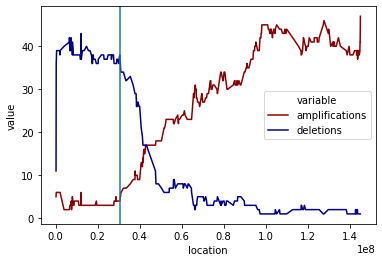

In [26]:
sns.lineplot(x="location", y="value", hue="variable", palette=['darkred', 'darkblue'], data=luad_counts_8)
plt.axvline(deletion_event)

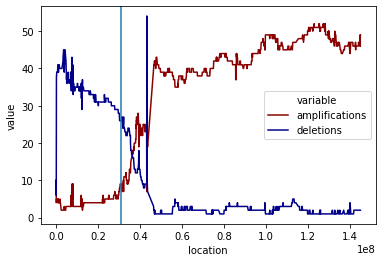

In [27]:
sns.lineplot(x="location", y="value", hue="variable", palette=['darkred', 'darkblue'], data=hnscc_counts_8)
plt.axvline(deletion_event)

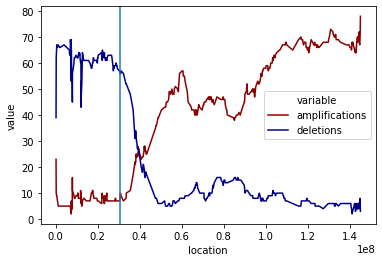

In [28]:
sns.lineplot(x="location", y="value", hue="variable", palette=['darkred', 'darkblue'], data=ovarian_counts_8)
plt.axvline(deletion_event)

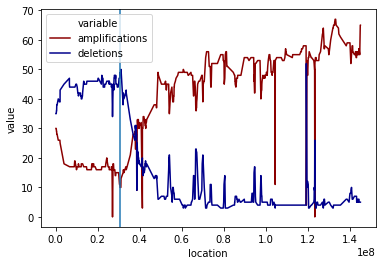

In [29]:
sns.lineplot(x="location", y="value", hue="variable", palette=['darkred', 'darkblue'], data=colon_counts_8)
plt.axvline(deletion_event)

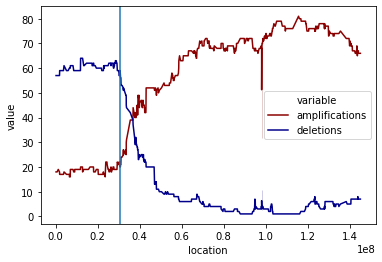

In [30]:
sns.lineplot(x="location", y="value", hue="variable", palette=['darkred', 'darkblue'], data=brca_counts_8)
plt.axvline(deletion_event)

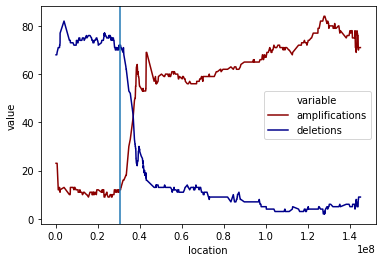

In [31]:
sns.lineplot(x="location", y="value", hue="variable", palette=['darkred', 'darkblue'], data=lscc_counts_8)
plt.axvline(deletion_event)

## Get Genes of Event

In [32]:
def calc_percent(row):
    values = list(row)
    return(len([x for x in values if x <= -0.2]) / len(values))

In [33]:
luad_gene_list = list(luad_counts_cleaned_8[luad_counts_cleaned_8.location < deletion_event].index)
hnscc_gene_list = list(hnscc_counts_cleaned_8[hnscc_counts_cleaned_8.location < deletion_event].index)
ovarian_gene_list = list(ovarian_counts_cleaned_8[ovarian_counts_cleaned_8.location < deletion_event].index)
colon_gene_list = list(colon_counts_cleaned_8[colon_counts_cleaned_8.location < deletion_event].index)
brca_gene_list = list(brca_counts_cleaned_8[brca_counts_cleaned_8.location < deletion_event].index)
lscc_gene_list = list(lscc_counts_cleaned_8[lscc_counts_cleaned_8.location < deletion_event].index)

In [34]:
len(list(luad_gene_list))

186

In [35]:
luad_df_before_event = luad_cnv[luad_gene_list]
hnscc_df_before_event = hnscc_cnv[hnscc_gene_list]
ovarian_df_before_event = ovarian_cnv[ovarian_gene_list]
colon_df_before_event = colon_cnv[colon_gene_list]
brca_df_before_event = brca_cnv[brca_gene_list]
lscc_df_before_event = lscc_cnv[lscc_gene_list]

In [36]:
luad_df_before_event['percent'] = luad_df_before_event.apply(calc_percent, axis=1)
hnscc_df_before_event['percent'] = hnscc_df_before_event.apply(calc_percent, axis=1)
ovarian_df_before_event['percent'] = ovarian_df_before_event.apply(calc_percent, axis=1)
colon_df_before_event['percent'] = colon_df_before_event.apply(calc_percent, axis=1)
brca_df_before_event['percent'] = brca_df_before_event.apply(calc_percent, axis=1)
lscc_df_before_event['percent'] = lscc_df_before_event.apply(calc_percent, axis=1)

C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

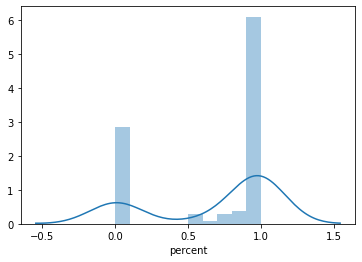

In [80]:
sns.distplot(lscc_df_before_event.percent, bins=10)

## Group Samples

In [37]:
luad_has_event = list(luad_df_before_event[luad_df_before_event.percent > .8].index)
hnscc_has_event = list(hnscc_df_before_event[hnscc_df_before_event.percent > .8].index)
ovarian_has_event = list(ovarian_df_before_event[ovarian_df_before_event.percent > .8].index)
colon_has_event = list(colon_df_before_event[colon_df_before_event.percent > .8].index)
brca_has_event = list(brca_df_before_event[brca_df_before_event.percent > .8].index)
lscc_has_event = list(lscc_df_before_event[lscc_df_before_event.percent > .8].index)

In [38]:
luad_no_event = [x for x in luad_df_before_event.index if x not in luad_has_event]
hnscc_no_event = [x for x in hnscc_df_before_event.index if x not in hnscc_has_event]
ovarian_no_event = [x for x in ovarian_df_before_event.index if x not in ovarian_has_event]
colon_no_event = [x for x in colon_df_before_event.index if x not in colon_has_event]
brca_no_event = [x for x in brca_df_before_event.index if x not in brca_has_event]
lscc_no_event = [x for x in lscc_df_before_event.index if x not in lscc_has_event]

In [39]:
gene_lists = {'LUAD': {'has_event': luad_has_event, 'no_event': luad_no_event},
             'HNSCC': {'has_event': hnscc_has_event, 'no_event': hnscc_no_event},
             'OVARIAN': {'has_event': ovarian_has_event, 'no_event': ovarian_no_event},
             'COLON': {'has_event': colon_has_event, 'no_event': colon_no_event},
             'BRCA': {'has_event': brca_has_event, 'no_event': brca_no_event},
             'LSCC': {'has_event': lscc_has_event, 'no_event': lscc_no_event}}

In [40]:
print("LUAD")
print("Yes", len(luad_has_event), "No", len(luad_no_event))
print("HNSCC")
print("Yes", len(hnscc_has_event), "No", len(hnscc_no_event))
print("OVARIAN")
print("Yes", len(ovarian_has_event), "No", len(ovarian_no_event))
print("COLON")
print("Yes", len(colon_has_event), "No", len(colon_no_event))
print("BRCA")
print("Yes", len(brca_has_event), "No", len(brca_no_event))
print("LSCC")
print("Yes", len(lscc_has_event), "No", len(lscc_no_event))

LUAD
Yes 34 No 75
HNSCC
Yes 30 No 79
OVARIAN
Yes 51 No 49
COLON
Yes 41 No 64
BRCA
Yes 57 No 65
LSCC
Yes 70 No 38


## Run T Tests

In [41]:
def t_test(col, cancer):
    has_ev = col[col.index.isin(gene_lists[cancer]['has_event'])]
    no_ev = col[col.index.isin(gene_lists[cancer]['no_event'])]
    return stats.ttest_ind(has_ev, no_ev)

In [42]:
luad_t_test = luad_prot.apply(lambda x: t_test(x, "LUAD")).transpose()
hnscc_t_test = hnscc_prot.apply(lambda x: t_test(x, "HNSCC")).transpose()
ovarian_t_test = ovarian_prot.apply(lambda x: t_test(x, "OVARIAN")).transpose()
colon_t_test = colon_prot.apply(lambda x: t_test(x, "COLON")).transpose()
brca_t_test = brca_prot.apply(lambda x: t_test(x, "BRCA")).transpose()
lscc_t_test = lscc_prot.apply(lambda x: t_test(x, "LSCC")).transpose()

C:\Users\chels\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\chels\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\chels\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [43]:
hnscc_t_test = hnscc_t_test.to_frame()
hnscc_t_test['hnscc_stat'] = [x[0] for x in hnscc_t_test[0]]
hnscc_t_test['hnscc_pvalue'] = [x[1] for x in hnscc_t_test[0]]

In [44]:
colon_t_test = colon_t_test.to_frame()
colon_t_test['colon_stat'] = [x[0] for x in colon_t_test[0]]
colon_t_test['colon_pvalue'] = [x[1] for x in colon_t_test[0]]

In [45]:
luad_t_test = luad_t_test.rename(columns={0:"luad_stat", 1:"luad_pvalue"})
ovarian_t_test = ovarian_t_test.rename(columns={0:"ovarian_stat", 1:"ovarian_pvalue"})
brca_t_test = brca_t_test.rename(columns={0:"brca_stat", 1:"brca_pvalue"})
lscc_t_test = lscc_t_test.rename(columns={0:"lscc_stat", 1:"lscc_pvalue"})

In [46]:
colon_t_test = colon_t_test.drop([0], axis=1)
hnscc_t_test = hnscc_t_test.drop([0], axis=1)

In [47]:
# Rename the database_id in the tables with multiindex
luad_t_test.index = luad_t_test.index.rename("Database_ID_Luad", level=1)
ovarian_t_test.index = ovarian_t_test.index.rename("Database_ID_Ovarian", level=1)
brca_t_test.index = brca_t_test.index.rename("Database_ID_Brca", level=1)
lscc_t_test.index = lscc_t_test.index.rename("Database_ID_Lscc", level=1)

In [48]:
luad_t_test

,,luad_stat,luad_pvalue
Name,Database_ID_Luad,,
A1BG,NP_570602.2,-2.106105,0.037534
A2M,NP_000005.2|NP_001334353.1|NP_001334354.1|K4JDR8|K4JBA2|K4JB97,-1.659181,0.100008
AAAS,NP_056480.1|NP_001166937.1,2.025836,0.045270
AACS,NP_076417.2|NP_001306769.1|NP_001306768.1,-0.324608,0.746112
AADAC,NP_001077.2,NaN,NaN
...,...,...,...
ZXDC,NP_079388.3|NP_001035743.1,NaN,NaN
ZYG11B,NP_078922.1,3.776772,0.000261
ZYX,NP_001010972.1|NP_001349712.1,-0.732300,0.465586


In [49]:
results = colon_t_test.join(brca_t_test).join(luad_t_test).join(hnscc_t_test).join(ovarian_t_test).join(lscc_t_test)

In [50]:
results_with_loc = add_chromo_and_loc(results)

In [51]:
def outside_event(x):
    a = x['chromo'] != '8'
    b = x['location'] > deletion_event
    return a|b

In [52]:
results_trans = results_with_loc[results_with_loc.apply(lambda x: outside_event(x), axis=1)]

In [53]:
luad_trans_proteins = list(set(results_trans[results_trans.luad_pvalue <= 0.05].index.get_level_values(0)))
ovarian_trans_proteins = list(set(results_trans[results_trans.ovarian_pvalue <= 0.05].index.get_level_values(0)))
hnscc_trans_proteins = list(set(results_trans[results_trans.hnscc_pvalue <= 0.05].index.get_level_values(0)))
colon_trans_proteins = list(set(results_trans[results_trans.colon_pvalue <= 0.05].index.get_level_values(0)))
brca_trans_proteins = list(set(results_trans[results_trans.brca_pvalue <= 0.05].index.get_level_values(0)))
lscc_trans_proteins = list(set(results_trans[results_trans.lscc_pvalue <= 0.05].index.get_level_values(0)))

In [54]:
luad_proteins = list(set(luad_t_test[luad_t_test.luad_pvalue < 0.05].index.get_level_values(0)))
hnscc_proteins = list(set(hnscc_t_test[hnscc_t_test.hnscc_pvalue < 0.05].index.get_level_values(0)))
ovarian_proteins = list(set(ovarian_t_test[ovarian_t_test.ovarian_pvalue < 0.05].index.get_level_values(0)))
colon_proteins = list(set(colon_t_test[colon_t_test.colon_pvalue < 0.05].index.get_level_values(0)))
brca_proteins = list(set(brca_t_test[brca_t_test.brca_pvalue < 0.05].index.get_level_values(0)))
lscc_proteins = list(set(lscc_t_test[lscc_t_test.lscc_pvalue < 0.05].index.get_level_values(0)))

In [55]:
aliases = ['MYC', 'CMYC', 'MYCC', "MRTL", 'BHLHE39']

In [56]:
luad_prot[luad_prot.columns[luad_prot.columns.get_level_values(0).str.startswith('MYC')]].columns.get_level_values(0)

Index(['MYCBP', 'MYCBP2'], dtype='object', name='Name')

In [57]:
def CountFrequency(my_list): 
  """
  Counts the frequency of the gene in the given list.
  Returns a list of genes that appeared 3 or more times.
  """
  freq = {} 
  for items in my_list: 
      freq[items] = my_list.count(items) 
  sig = []
  for key, value in freq.items(): 
    if value >= 5:
        print(key, value)
        sig.append(key)
  return sig

In [58]:
common_proteins = CountFrequency(luad_proteins +
                                hnscc_proteins +
                                ovarian_proteins +
                                colon_proteins +
                                brca_proteins +
                                lscc_proteins)

PCM1 6
AGPAT5 6
CCAR2 6
SH2D4A 6
KIF13B 5
FDFT1 5
PPP2R1A 5
ERI1 5
ATP6V1H 5
CHMP7 6
PPP2R2A 6
NAT1 6
VPS37A 5
XPO7 6
ATP6V1B2 6
CCDC25 6
PPP2CB 5


In [59]:
common_trans_proteins = CountFrequency(luad_trans_proteins +
                                hnscc_trans_proteins +
                                ovarian_trans_proteins +
                                colon_trans_proteins +
                                brca_trans_proteins +
                                lscc_trans_proteins)

PPP2R1A 5
ATP6V1H 5


In [60]:
print(common_trans_proteins)

['PPP2R1A', 'ATP6V1H']


In [61]:
lscc_t_test[lscc_t_test.lscc_pvalue < 0.0000000005]

,,lscc_stat,lscc_pvalue
Name,Database_ID_Lscc,,
CCAR2,NP_066997.3,-7.723916,6.698630e-12
PPP2R2A,NP_002708.1|NP_001171062.1,-7.450417,2.628044e-11
XPO7,NP_055839.3|NP_001093631.1|NP_001349731.1,-7.085443,1.593026e-10


In [62]:
def all_low_pvalues(row):
    return ((row['luad_pvalue'] < 0.1) & (row['ovarian_pvalue'] < 0.1) & (row['hnscc_pvalue'] < 0.1) & (row['colon_pvalue'] < 0.1) & (row['brca_pvalue'] < 0.1) & (row['lscc_pvalue'] < 0.1))

In [63]:
common_low_pvalues = results[results.apply(lambda x: all_low_pvalues(x), axis=1)]

In [64]:
common_low_pvalues

colon_stat  \
Name     Database_ID_Ovarian Database_ID_Brca                                   Database_ID_Luad                                   Database_ID_Lscc                                                 
AGPAT5   NP_060831           NP_060831.2                                        NP_060831.2                                        NP_060831.2                                          -3.740606   
ATP6V1B2 NP_001684           NP_001684.2                                        NP_001684.2                                        NP_001684.2                                          -7.175850   
ATP6V1H  NP_998785           NP_998785.1|NP_998784.1                            NP_057025.2|NP_998784.1                            NP_057025.2|NP_998784.1                              -5.256869   
CCAR2    NP_066997           NP_066997.3                                        NP_066997.3                                        NP_001349997.1                                       -5.098770   
                                                                                                                                   NP_066997.3                                          -5.098770   
CCDC25   NP_060716           NP_060716.2|NP_001291461.1|NP_001291459.1|NP_00... NP_060716.2|NP_001291461.1|NP_001291458.1          NP_060716.2|NP_001291461.1|NP_001291458.1            -3.286007   
CHMP7    NP_689485           NP_689485.1|NP_001304828.1                         NP_689485.1|NP_001350112.1|NP_001304828.1          NP_689485.1|NP_001304828.1|NP_001350112.1            -3.741828   
FDFT1    NP_001274671        NP_001274671.1|NP_001274679.1|NP_001274673.1|NP... NP_001274671.1|NP_001274679.1|NP_001274673.1|NP... NP_001274671.1|NP_001274679.1|NP_001274673.1|NP...   -4.630485   
IGLL5    NP_001171597        NP_001171597.1|NP_001243225.1                      NP_001171597.1|NP_001243225.1                      NP_001171597.1|NP_001243225.1                        -2.252785   
NAT1     NP_001153651        NP_001153651.1|NP_001278891.1                      NP_000653.3|NP_001153647.1                         NP_000653.3|NP_001153647.1                           -4.129058   
PCM1     NP_006188           NP_006188.3|NP_001302437.1                         NP_001339561.1|NP_001339563.1|NP_001339568.1|NP... NP_001339564.1|NP_001302436.1|NP_001339562.1|NP...   -6.853395   
PPP2R2A  NP_001171062        NP_002708.1|NP_001171062.1                         NP_002708.1|NP_001171062.1                         NP_002708.1|NP_001171062.1                           -8.186369   
SH2D4A   NP_071354           NP_071354.2|NP_001167631.1                         NP_001167630.1|NP_001350039.1|NP_001167631.1       NP_001167630.1|NP_001350039.1|NP_001167631.1         -5.755219   
XPO7     NP_055839           NP_055839.3                                        NP_001349731.1|NP_001093631.1                      NP_055839.3|NP_001093631.1|NP_001349731.1            -8.052469   

                                                                                                                                                                                       colon_pvalue  \
Name     Database_ID_Ovarian Database_ID_Brca                                   Database_ID_Luad                                   Database_ID_Lscc                                                   
AGPAT5   NP_060831           NP_060831.2                                        NP_060831.2                                        NP_060831.2                                         3.172975e-04   
ATP6V1B2 NP_001684           NP_001684.2                                        NP_001684.2                                        NP_001684.2                                         1.715074e-10   
ATP6V1H  NP_998785           NP_998785.1|NP_998784.1                            NP_057025.2|NP_998784.1                            NP_057025.2|NP_998784.1                             9.296203e-07   
CCAR2    NP_066997           NP_066

In [65]:
common_low_pvalues_cleaned = common_low_pvalues.drop(columns=['chromo', 'location'])

In [66]:
common_low_pvalues_cleaned.index = common_low_pvalues_cleaned.index.droplevel([1,2,3,4])

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import six

In [68]:
!pip install scinot

  Using cached scinot-0.0.11-py3-none-any.whl (4.9 kB)


In [69]:
import scinot

In [70]:
scinot.start(sigfigs=1, thresh=2)

In [71]:
common_low_pvalues_cleaned = common_low_pvalues_cleaned.applymap(lambda x: scinot.format(x, 3) )

In [72]:
common_low_pvalues_cleaned.reset_index(inplace=True)

In [73]:

def render_mpl_table(data, col_width=2.2, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

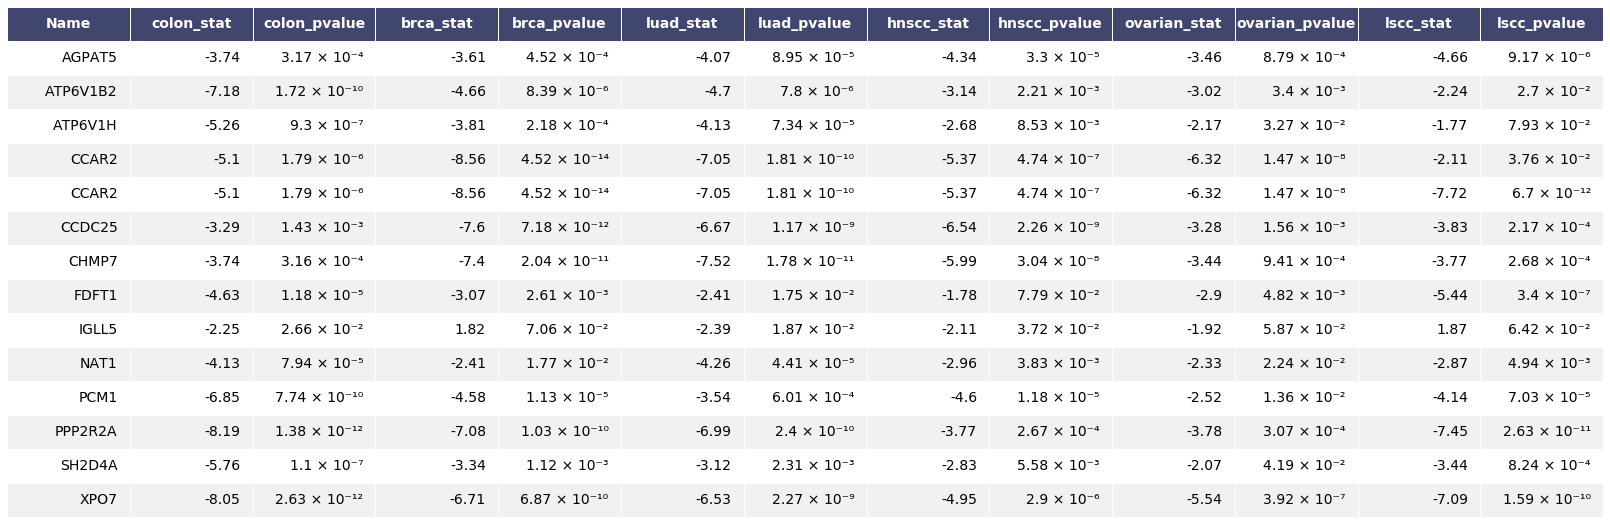

In [74]:
render_mpl_table(common_low_pvalues_cleaned)